# Deep Learning Options Trading - Feature Analysis

This notebook analyzes the engineered features for **individual option contracts** from Databento:
- Feature importance and predictive power for option pricing
- Correlation with option prices (calls/puts from OHLCV data)
- Stationarity and time series properties
- Feature engineering validation

**Note:** Databento OHLCV schema provides individual contract data. Straddle construction happens at strategy execution, not in raw data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import adfuller
from pathlib import Path
import yaml
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

## 1. Load Engineered Features

In [6]:
# Load features and targets
try:
    features_df = pd.read_csv('../data/processed/features.csv')
    features_df['date'] = pd.to_datetime(features_df['date'])
    print(f"Loaded features: {len(features_df)} records")
    print(f"Columns: {features_df.columns.tolist()}")
    
    # Separate features and target
    # Target is option_price (individual contracts, not straddles)
    feature_cols = [col for col in features_df.columns 
                   if col not in ['date', 'ticker', 'option_price', 'option_symbol']]
    
    target_col = 'option_price'
    X = features_df[feature_cols]
    y = features_df[target_col]
    
    print(f"\nFeatures ({len(feature_cols)}): {feature_cols}")
    print(f"Target: {target_col}")
    print(f"\nData shape: X={X.shape}, y={y.shape}")
except FileNotFoundError:
    print("Features not found. Run feature engineering first.")
    X, y = None, None

Loaded features: 9000 records
Columns: ['date', 'ticker', 'option_price', 'option_volume', 'option_premium_normalized', 'underlying_price', 'underlying_return_1d', 'underlying_volatility_30d', 'option_symbol', 'option_price_ma5', 'option_price_std5', 'volume_ma5']

Features (8): ['option_volume', 'option_premium_normalized', 'underlying_price', 'underlying_return_1d', 'underlying_volatility_30d', 'option_price_ma5', 'option_price_std5', 'volume_ma5']
Target: option_price

Data shape: X=(9000, 8), y=(9000,)


In [17]:
#investigate feature distributions and relationships with target 
features_df.tail(10)

,date,ticker,option_price,option_volume,option_premium_normalized,underlying_price,underlying_return_1d,underlying_volatility_30d,option_symbol,option_price_ma5,option_price_std5,volume_ma5
8990,2025-10-28,AMZN,13.75,2,0.059978,229.25,NaN,NaN,AMZN 270115C00310000,21.290,6.613188,17.4
8991,2025-10-28,AMZN,32.00,8,0.139586,229.25,NaN,NaN,AMZN 251121C00197500,22.490,8.066241,15.8
8992,2025-10-28,AMZN,34.50,6,0.150491,229.25,NaN,NaN,AMZN 251121C00197500,24.140,9.704986,15.2
8993,2025-10-28,AMZN,67.54,3,0.294613,229.25,NaN,NaN,AMZN 271217C00205000,32.428,21.868989,4.2
8994,2025-10-28,AMZN,26.55,4,0.115812,229.25,NaN,NaN,AMZN 270617C00285000,34.868,19.943542,4.6
8995,2025-10-28,AMZN,71.54,2,0.312061,229.25,NaN,NaN,AMZN 280121C00200000,46.426,21.341909,4.6
8996,2025-10-28,AMZN,70.30,7,0.306652,229.25,NaN,NaN,AMZN 280121C00200000,54.086,21.739300,4.4
8997,2025-10-28,AMZN,70.90,2,0.309269,229.25,NaN,NaN,AMZN 280121C00200000,61.366,19.522397,3.6
8998,2025-10-28,AMZN,71.33,2,0.311145,229.25,NaN,NaN,AMZN 280121C00200000,62.124,19.892122,3.4
8999,2025-10-28,AMZN,70.19,5,0.306172,229.25,NaN,NaN,AMZN 280121C00200000,70.852,0.601473,3.6


## 2. Feature Correlation Analysis

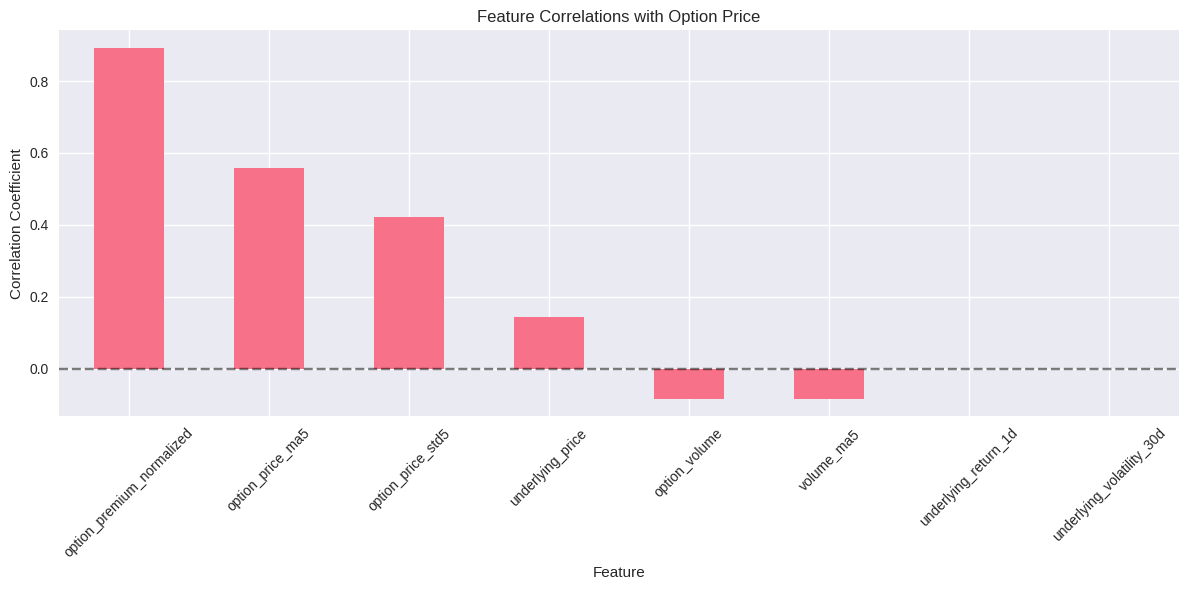

Top 5 positive correlations:
option_premium_normalized    0.892270
option_price_ma5             0.557370
option_price_std5            0.421744
underlying_price             0.145251
option_volume               -0.083648
dtype: float64

Top 5 negative correlations:
underlying_price             0.145251
option_volume               -0.083648
volume_ma5                  -0.083812
underlying_return_1d              NaN
underlying_volatility_30d         NaN
dtype: float64


In [9]:
if X is not None:
    # Correlation with target
    correlations = X.corrwith(y).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    correlations.plot(kind='bar')
    plt.title('Feature Correlations with Option Price')
    plt.xlabel('Feature')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print("Top 5 positive correlations:")
    print(correlations.head())
    print("\nTop 5 negative correlations:")
    print(correlations.tail())

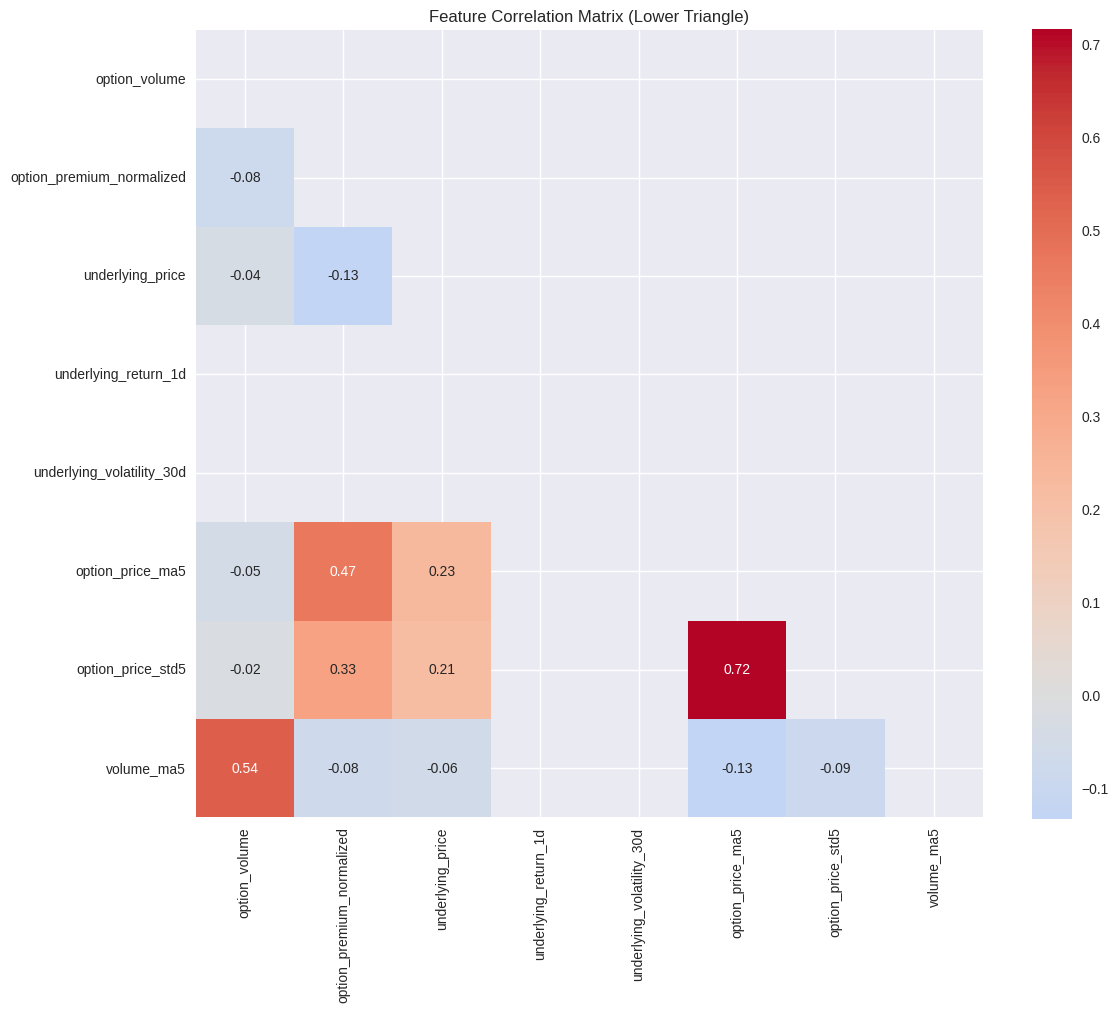

No highly correlated feature pairs found.


In [10]:
if X is not None:
    # Feature-to-feature correlations
    plt.figure(figsize=(12, 10))
    corr_matrix = X.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
    plt.title('Feature Correlation Matrix (Lower Triangle)')
    plt.tight_layout()
    plt.show()
    
    # Identify highly correlated features
    high_corr = np.where(np.abs(corr_matrix) > 0.8)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                      for x, y in zip(*high_corr) if x != y and x < y]
    
    if high_corr_pairs:
        print("Highly correlated feature pairs (|corr| > 0.8):")
        for pair in high_corr_pairs:
            corr_value = corr_matrix.loc[pair[0], pair[1]]
            print(f"{pair[0]} - {pair[1]}: {corr_value:.3f}")
    else:
        print("No highly correlated feature pairs found.")

## 3. Feature Importance Analysis

In [11]:
if X is not None:
    # Mutual information
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    mi_scores.plot(kind='bar')
    plt.title('Feature Importance (Mutual Information)')
    plt.xlabel('Feature')
    plt.ylabel('Mutual Information Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Mutual Information Scores:")
    for feature, score in mi_scores.items():
        print(f"{feature}: {score:.4f}")

ValueError: Input X contains NaN.

In [12]:
if X is not None:
    # Linear regression coefficients
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lr = LinearRegression()
    lr.fit(X_scaled, y)
    
    # Get coefficients
    coefficients = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    coefficients.plot(kind='bar')
    plt.title('Linear Regression Coefficients (Standardized)')
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Value')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print(f"R² Score: {lr.score(X_scaled, y):.4f}")
    print("\nTop positive coefficients:")
    print(coefficients.head())
    print("\nTop negative coefficients:")
    print(coefficients.tail())

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 4. Stationarity Testing

In [13]:
if X is not None:
    # Augmented Dickey-Fuller test for stationarity
    stationarity_results = {}
    
    for col in X.columns:
        try:
            adf_result = adfuller(X[col].dropna())
            stationarity_results[col] = {
                'adf_statistic': adf_result[0],
                'p_value': adf_result[1],
                'critical_values': adf_result[4],
                'stationary': adf_result[1] < 0.05
            }
        except:
            stationarity_results[col] = {'error': 'Could not test stationarity'}
    
    # Display results
    print("Stationarity Test Results (Augmented Dickey-Fuller):")
    print("=" * 60)
    
    for feature, result in stationarity_results.items():
        if 'error' not in result:
            print(f"{feature}:")
            print(f"  ADF Statistic: {result['adf_statistic']:.4f}")
            print(f"  p-value: {result['p_value']:.4f}")
            print(f"  Stationary: {result['stationary']}")
            print(f"  5% Critical Value: {result['critical_values']['5%']:.4f}")
            print()
        else:
            print(f"{feature}: {result['error']}")
    
    # Summary
    stationary_features = [f for f, r in stationarity_results.items() 
                          if 'stationary' in r and r['stationary']]
    non_stationary_features = [f for f, r in stationarity_results.items() 
                              if 'stationary' in r and not r['stationary']]
    
    print(f"\nStationary features: {len(stationary_features)}/{len(X.columns)}")
    print(f"Non-stationary features: {len(non_stationary_features)}/{len(X.columns)}")
    
    if non_stationary_features:
        print(f"\nNon-stationary features: {', '.join(non_stationary_features)}")
        print("Consider differencing or other transformations for LSTM input.")

Stationarity Test Results (Augmented Dickey-Fuller):
option_volume:
  ADF Statistic: -34.3061
  p-value: 0.0000
  Stationary: True
  5% Critical Value: -2.8619

option_premium_normalized:
  ADF Statistic: -12.2616
  p-value: 0.0000
  Stationary: True
  5% Critical Value: -2.8619

underlying_price:
  ADF Statistic: -1.4264
  p-value: 0.5696
  Stationary: False
  5% Critical Value: -2.8619

underlying_return_1d: Could not test stationarity
underlying_volatility_30d: Could not test stationarity
option_price_ma5:
  ADF Statistic: -11.5426
  p-value: 0.0000
  Stationary: True
  5% Critical Value: -2.8619

option_price_std5:
  ADF Statistic: -22.3914
  p-value: 0.0000
  Stationary: True
  5% Critical Value: -2.8619

volume_ma5:
  ADF Statistic: -13.2441
  p-value: 0.0000
  Stationary: True
  5% Critical Value: -2.8619


Stationary features: 5/8
Non-stationary features: 1/8

Non-stationary features: underlying_price
Consider differencing or other transformations for LSTM input.


## 5. Time Series Properties

In [ ]:
if X is not None:
    # Autocorrelation analysis for key features
    from statsmodels.graphics.tsaplots import plot_acf
    
    # Use features that actually exist in our data
    key_features = ['option_premium_normalized', 'underlying_return_1d', 'underlying_volatility_30d', 'option_price_ma5']
    key_features = [f for f in key_features if f in X.columns]
    
    fig, axes = plt.subplots(len(key_features), 1, figsize=(12, 4*len(key_features)))
    if len(key_features) == 1:
        axes = [axes]
    
    for i, feature in enumerate(key_features):
        plot_acf(X[feature].dropna(), lags=30, ax=axes[i], title=f'Autocorrelation - {feature}')
    
    plt.tight_layout()
    plt.show()

In [ ]:
if X is not None:
    # Rolling statistics to check for structural breaks
    # Note: Using smaller window since our test data is only ~120 days
    fig, axes = plt.subplots(len(feature_cols), 1, figsize=(15, 3*len(feature_cols)))
    if len(feature_cols) == 1:
        axes = [axes]
    
    window = 30  # 30-day rolling window (adjust to 252 for full dataset)
    
    for i, feature in enumerate(feature_cols):
        rolling_mean = X[feature].rolling(window=window).mean()
        rolling_std = X[feature].rolling(window=window).std()
        
        ax1 = axes[i]
        ax1.plot(X[feature].index, X[feature].values, alpha=0.7, label='Feature')
        ax1.plot(X[feature].index, rolling_mean, color='red', label=f'{window}-day Mean')
        ax1.set_title(f'{feature} with Rolling Mean')
        ax1.legend()
        
        # Add secondary y-axis for std
        ax2 = ax1.twinx()
        ax2.plot(X[feature].index, rolling_std, color='green', alpha=0.7, label=f'{window}-day Std')
        ax2.set_ylabel('Rolling Std', color='green')
        ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

## 6. Feature Engineering Validation

In [ ]:
if X is not None:
    # Check for outliers
    fig, axes = plt.subplots(len(feature_cols), 1, figsize=(12, 3*len(feature_cols)))
    if len(feature_cols) == 1:
        axes = [axes]
    
    for i, feature in enumerate(feature_cols):
        # Box plot for outlier detection
        axes[i].boxplot(X[feature].dropna(), vert=False)
        axes[i].set_title(f'Box Plot - {feature}')
        axes[i].set_xlabel(feature)
    
    plt.tight_layout()
    plt.show()
    
    # Outlier statistics
    outlier_stats = {}
    for feature in feature_cols:
        data = X[feature].dropna()
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_stats[feature] = {
            'outlier_count': len(outliers),
            'outlier_percentage': len(outliers) / len(data) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
    
    print("Outlier Analysis:")
    for feature, stats in outlier_stats.items():
        print(f"{feature}: {stats['outlier_count']} outliers ({stats['outlier_percentage']:.2f}%)")

## 7. Feature Analysis Summary

In [ ]:
# Generate comprehensive feature analysis report
if X is not None:
    print("=== FEATURE ANALYSIS SUMMARY ===\n")
    
    # Feature overview
    print(f"Total features: {len(feature_cols)}")
    print(f"Total samples: {len(X)}")
    print(f"Missing values: {X.isnull().sum().sum()}")
    
    # Predictive power ranking
    print("\nTop 5 features by correlation with target:")
    top_corr = correlations.head()
    for i, (feature, corr) in enumerate(top_corr.items(), 1):
        print(f"{i}. {feature}: {corr:.4f}")
    
    print("\nTop 5 features by mutual information:")
    top_mi = mi_scores.head()
    for i, (feature, mi) in enumerate(top_mi.items(), 1):
        print(f"{i}. {feature}: {mi:.4f}")
    
    # Stationarity summary
    stationary_count = sum(1 for r in stationarity_results.values() if r.get('stationary', False))
    print(f"\nStationary features: {stationary_count}/{len(feature_cols)}")
    
    # Data quality
    total_outliers = sum(stats['outlier_count'] for stats in outlier_stats.values())
    avg_outlier_pct = np.mean([stats['outlier_percentage'] for stats in outlier_stats.values()])
    print(f"Total outliers: {total_outliers}")
    print(f"Average outlier percentage: {avg_outlier_pct:.2f}%")
    
    # Recommendations
    print("\n=== RECOMMENDATIONS ===")
    
    if non_stationary_features:
        print(f"Consider differencing for non-stationary features: {', '.join(non_stationary_features[:3])}...")
    
    if avg_outlier_pct > 5:
        print("High outlier percentage detected. Consider robust scaling or outlier treatment.")
    
    low_corr_features = correlations[correlations.abs() < 0.1]
    if len(low_corr_features) > 0:
        print(f"Consider removing low-correlation features: {', '.join(low_corr_features.index[:3])}...")
    
    print("\n=== ANALYSIS COMPLETE ===")
else:
    print("Features not available for analysis. Run feature engineering first.")